In [12]:
import sys
!{sys.executable} -m pip install deap

In [13]:
import sys
!{sys.executable} -m pip install pyswarms

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pyswarms as ps
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from deap import base, creator, tools, algorithms
from pyswarms.utils.functions import single_obj as fx
import random

# Load dataset (using the JM1 dataset as an example)
data = pd.read_csv('./jm1.csv')

# Drop any missing values
data = data.dropna()

# Separate features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]


# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [15]:
# Define the evaluation function for PSO
def evalFeatureSelection(x):
    n_particles = x.shape[0]
    fitness = []

    for i in range(n_particles):
        individual = [1 if val > 0.5 else 0 for val in x[i]]
        selected_features = [i for i, val in enumerate(individual) if val == 1]

        if len(selected_features) == 0:
            fitness.append(0)
            continue
        
        X_train_selected = X_train.iloc[:, selected_features]
        X_test_selected = X_test.iloc[:, selected_features]

        clf = SVC()
        clf.fit(X_train_selected, y_train)
        y_pred = clf.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)
        fitness.append(accuracy)
    
    return np.array(fitness)

In [16]:
# Configure the PSO algorithm:
n_features = X_train.shape[1]
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
bounds = (np.zeros(n_features), np.ones(n_features))
optimizer = ps.single.GlobalBestPSO(n_particles=30, dimensions=n_features, options=options, bounds=bounds)


In [17]:
# Run the PSO algorithm for feature selection:
cost, pos = optimizer.optimize(evalFeatureSelection, iters=20, verbose=True)

2023-08-30 10:14:31,436 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████|20/20, best_cost=0.801
2023-08-30 10:22:08,758 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8014705882352942, best pos: [0.40207087 0.63928776 0.19211188 0.29295473 0.36142104 0.36895544
 0.2350057  0.86663882 0.09875831 0.33332658 0.20701276 0.10768449
 0.26007568 0.21081751 0.36226132 0.3130024  0.61444604 0.54249642
 0.06845327 0.2100363  0.98018008]


In [18]:
# Train and evaluate the Naive Bayes classifier using the best feature subset found:
best_individual = [1 if val > 0.5 else 0 for val in pos]
selected_features = [i for i, val in enumerate(best_individual) if val == 1]
print("Number of selected features: ", len(selected_features))

Number of selected features:  5


In [19]:
# Train the classifier
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
clf = SVC(probability=True)
clf.fit(X_train_selected, y_train)

# Test the classifier
y_pred = clf.predict(X_test_selected)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.8014705882352942
              precision    recall  f1-score   support

       False       0.81      0.99      0.89      2619
        True       0.48      0.05      0.09       645

    accuracy                           0.80      3264
   macro avg       0.64      0.52      0.49      3264
weighted avg       0.74      0.80      0.73      3264



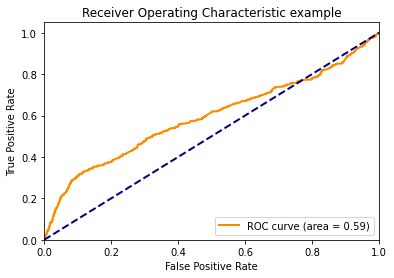

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# probabilities for the positive outcome
y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # false positive rate and true positive rate
roc_auc = roc_auc_score(y_test, y_pred_proba)

df = pd.DataFrame({
    'FPR': fpr,
    'TPR': tpr,
    'AUC': roc_auc
})
df.to_csv('./AUC_Extracts/CM1/CM1_SVM_PSO.csv', index=False)

# Plot
plt.figure()
lw = 2  # line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic example')
plt.legend(loc="lower right")
plt.show()